In [2]:
# 필요 라이브러리 가져오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, svm, datasets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Iris 데이터셋 가져오기
iris = datasets.load_iris()

# Iris 데이터를 사용한 데이터프레임 생성
iris.feature_names = ['sepal length (cm)', 'sepal width (cm)', 
                      'petal length (cm)', 'petal width (cm)'] #Iris 데이터의 feature 설정
df = pd.DataFrame(iris.data, columns=iris.feature_names) #Rris 데이터를 데이터프레임으로 변환
df['target'] = iris.target #Iris 데이터의 타켓(레이블) 추가
df['flower_name'] = df.target.apply(lambda x: iris.target_names[x]) #target을 이용해 꽃 이름 추가

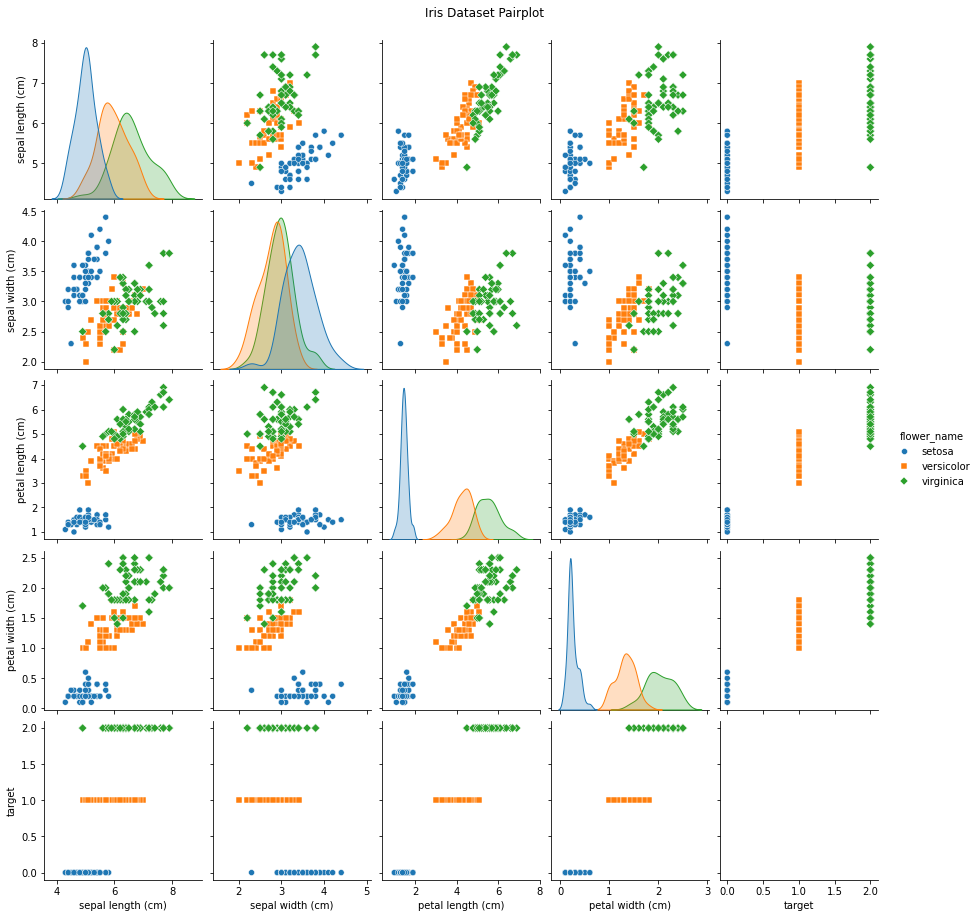

In [4]:
# Iris데이터를 pairplot으로 데이터 시각화하기
sns.pairplot(df, hue='flower_name', markers=["o", "s", "D"]) #꽃 이름별로 다른 모양으로 시각화
plt.suptitle('Iris Dataset Pairplot', y=1.02)
plt.show() #플롯 츌력하기

In [5]:
# 특징과 타겟 변수 정의
X = df.drop(['target', 'flower_name'], axis='columns')
y = df.target #iris 데이터의 타켓

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)  # 타겟 클래스 비율을 유지하는 stratify 옵션 추가

In [6]:
# 하이퍼파라미터 튜닝 시에 필요한 전처리를 위한 파이프라인 구성
pipeline = Pipeline([
    ('scaler', StandardScaler()), # 특징 데이터를 표준화 (평균 0, 분산 1)
    ('svm', svm.SVC()) # SVM 모델 사용
]) #파이프라인을 스케일링과 SVM으로 설정

# 하이퍼파라미터 그리드 정의 (파이프라인의 하이퍼파라미터 설정)
param_grid = {
    'svm__C': [0.1, 1, 10, 100], # 규제 파라미터 C 값 설정
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'], # 커널 함수 선택
    'svm__gamma': ['scale', 'auto'] # rbf, poly, sigmoid 커널을 사용할 때 gamma 값 설정
}

In [7]:
# GridSearchCV를 사용한 하이퍼파라미터 튜닝
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1) # 교차 검증으로 최적의 하이퍼파라미터 탐색
grid_search.fit(X_train, y_train) # 학습 데이터를 사용하여 모델 훈련 및 최적의 파라미터 찾기

# 최적의 파라미터와 성능 출력
print(f"최적의 하이퍼파라미터: {grid_search.best_params_}")
print(f"최적의 교차 검증 정확도: {grid_search.best_score_:.2f}")

#최적의 모델로 테스트 세트를 평가
best_model = grid_search.best_estimator_ # 최적의 파라미터로 설정된 모델을 가져옴
test_accuracy = best_model.score(X_test, y_test) # 테스트 세트에서 최적의 파라미터의 정확도 평가
print(f"테스트 세트 정확도: {test_accuracy:.2f}")

# 혼동 행렬과 분류 보고서 출력하기
y_pred = best_model.predict(X_test) # 테스트 데이터에 대한 예측 결과 생성
print("\n혼동 행렬:")
print(metrics.confusion_matrix(y_test, y_pred)) # 혼동 행렬 출력

print("\n분류 보고서:")
print(metrics.classification_report(y_test, y_pred, target_names=iris.target_names))

최적의 하이퍼파라미터: {'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
최적의 교차 검증 정확도: 0.97
테스트 세트 정확도: 0.93

혼동 행렬:
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]

분류 보고서:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



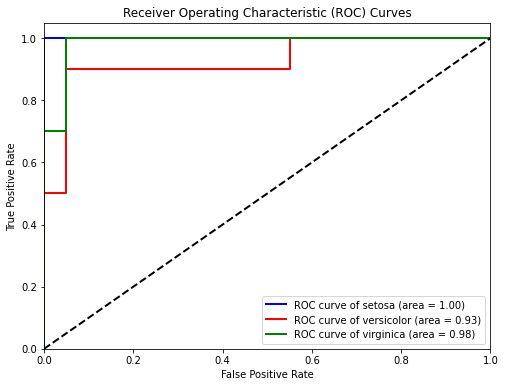

In [8]:
# ROC 곡선을 그리기 위해 각 클래스를 개별적인 이진 분류하는 코드
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2]) # 타겟을 이진 벡터 형식으로 변환 (다중 클래스 문제를 이진 분류 문제로 전환)
n_classes = y_test_binarized.shape[1] # 클래스의 개수 저장

# 확률 예측
y_score = best_model.decision_function(X_test) # 테스트 데이터에 대해 각 클래스에 대한 점수를 반환 (SVM에서 decision_function 사용)

# ROC 곡선 계산
fpr = dict()  # False Positive Rate 저장을 위한 딕셔너리
tpr = dict()  # True Positive Rate 저장을 위한 딕셔너리
roc_auc = dict() # ROC,AUC 값을 저장하기 위한 딕셔너리
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i]) # ROC 곡선 계산
    roc_auc[i] = auc(fpr[i], tpr[i]) # AUC 값 계산

# ROC 곡선 시각화
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green'] # 각 클래스에 대한 색상 지정
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {iris.target_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()
#ROC 곡선을 통해 다중 클래스 문제의 클래스 분류 성능 평가

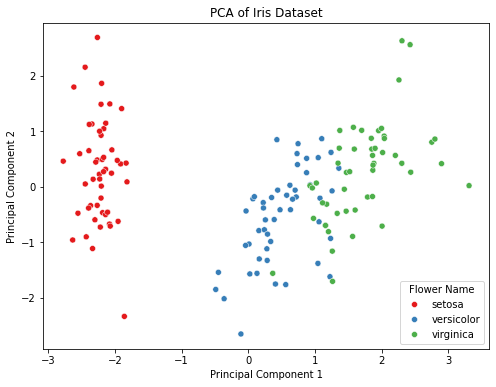

In [9]:
# PCA를 사용한 시각화
pca = PCA(n_components=2) # PCA 객체를 생성하고 주성분을 2개로 설정
X_pca = pca.fit_transform(StandardScaler().fit_transform(X)) # 데이터를 표준화하고 PCA를 적용하여 2차원으로 변환

# 학습 데이터와 테스트 데이터를 PCA로 변환
X_train_pca = pca.transform(StandardScaler().fit_transform(X_train))  # 학습 데이터를 PCA로 변환
X_test_pca = pca.transform(StandardScaler().fit_transform(X_test))  # 테스트 데이터를 PCA로 변환    

# PCA 시각화
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['flower_name'], palette='Set1')
plt.title('PCA of Iris Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Flower Name')
plt.show()
#PCA 시각화를 통해 데이터의 가장 적절한 방향의 평면을 찾아내기